# Model Training & Evaluation using PyCaret

## Phase 1

### Load & view the dataset

In [1]:
import pandas as pd
import os

In [2]:
# Actual dataset at: https://www.kaggle.com/fedesoriano/heart-failure-prediction
df = pd.read_csv("../data/heart.csv")   # This corresponds to v1 of the data containing lesser no. of samples
df.shape

(798, 12)

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Set up the PyCaret Training

In [4]:
from pycaret.classification import *

In [5]:
expt = setup(data = df, target = "HeartDisease", session_id=42, train_size=0.8)

,Description,Value
0,session_id,42
1,Target,HeartDisease
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(798, 12)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


### Explore the models available

In [6]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### Compare the performance of models & select the best model (based on F1 Score)

In [7]:
top_model = compare_models(sort="F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8809,0.9340,0.9159,0.8812,0.8959,0.7566,0.7627,0.1940
lr,Logistic Regression,0.8778,0.9364,0.9076,0.8804,0.8923,0.7509,0.7549,2.0350
ridge,Ridge Classifier,0.8715,0.0000,0.8992,0.8763,0.8863,0.7386,0.7418,0.0090
lda,Linear Discriminant Analysis,0.8715,0.9352,0.8992,0.8763,0.8863,0.7386,0.7418,0.0100
et,Extra Trees Classifier,0.8699,0.9342,0.9017,0.8730,0.8855,0.7347,0.7390,0.1370
lightgbm,Light Gradient Boosting Machine,0.8684,0.9309,0.9076,0.8673,0.8849,0.7312,0.7372,0.0400
gbc,Gradient Boosting Classifier,0.8667,0.9299,0.8990,0.8714,0.8828,0.7283,0.7335,0.0710
nb,Naive Bayes,0.8652,0.9216,0.8877,0.8744,0.8803,0.7259,0.7276,0.0110
ada,Ada Boost Classifier,0.8606,0.9129,0.8879,0.8680,0.8765,0.7165,0.7195,0.0680
dt,Decision Tree Classifier,0.8118,0.8109,0.8200,0.8394,0.8289,0.6200,0.6216,0.0090


### Inspect the performance of this model

In [8]:
evaluate_model(top_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Evaluate the model on the held out data 

In [9]:
predict_model(top_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9000,0.9223,0.9485,0.8932,0.9200,0.7870,0.7895


### Finalize & save the model

In [10]:
top_model_finalized = finalize_model(top_model)

In [11]:
os.makedirs("../models", exist_ok=True)
save_model(top_model_finalized, "../models/model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='HeartDisease',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
       

### Deploy the model & use it for inference

***

## Phase 2

*(Now, we simulate a scenario where after some time, we get more data & wish to retrain our model on this new data)*

### Load the new data

In [12]:
df = pd.read_csv("../data/heart.csv")   # This corresponds to v2 of the data containing more no. of samples
df.shape

(899, 12)

### Set up the experiment, this time with feature engineering

In [13]:
expt_intermediate = setup(
    data = df, 
    target = 'HeartDisease', 
    session_id=42,                      # Random seed to ensure reproducibility of the experiment with the same data
    train_size=0.8,                     # 80% training data & 20% held-out validation data
    normalize=True,
    normalize_method="minmax",
    polynomial_features=True,
    feature_interaction=True
)

,Description,Value
0,session_id,42
1,Target,HeartDisease
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(899, 12)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


### Compare the models & select top 3 models

In [14]:
top3 = compare_models(sort="F1", n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8692,0.0000,0.9045,0.8630,0.8820,0.7354,0.7392,0.0070
rf,Random Forest Classifier,0.8636,0.9218,0.9045,0.8564,0.8779,0.7237,0.7291,0.1940
lr,Logistic Regression,0.8650,0.9248,0.8918,0.8646,0.8769,0.7276,0.7302,1.6230
gbc,Gradient Boosting Classifier,0.8636,0.9253,0.8837,0.8718,0.8754,0.7246,0.7290,0.0960
lda,Linear Discriminant Analysis,0.8609,0.9213,0.8941,0.8571,0.8738,0.7188,0.7227,0.0140
et,Extra Trees Classifier,0.8594,0.9219,0.8861,0.8614,0.8716,0.7161,0.7203,0.1300
lightgbm,Light Gradient Boosting Machine,0.8525,0.9219,0.8707,0.8621,0.8644,0.7024,0.7064,0.0570
nb,Naive Bayes,0.8511,0.9094,0.8787,0.8509,0.8637,0.6995,0.7018,0.0100
ada,Ada Boost Classifier,0.8511,0.9029,0.8683,0.8615,0.8631,0.6997,0.7031,0.0680
knn,K Neighbors Classifier,0.8288,0.8857,0.8756,0.8241,0.8473,0.6528,0.6578,0.0330


### Fine-tune the top 3 models

*(We do fine-tuning based on default parameter value grid, but can also supply grid values manually)*

In [15]:
tuned_top3 = []
for m in top3:
    tuned_m = tune_model(m)
    tuned_top3.append(tuned_m)
    

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9444,0.9783,1.0000,0.9048,0.9500,0.8879,0.8935
1,0.9306,0.9613,0.8947,0.9714,0.9315,0.8613,0.8643
2,0.9028,0.9138,0.8974,0.9211,0.9091,0.8047,0.8050
3,0.8472,0.9270,0.8718,0.8500,0.8608,0.6916,0.6919
4,0.8194,0.9169,0.7949,0.8611,0.8267,0.6389,0.6411
5,0.8472,0.9021,0.8718,0.8500,0.8608,0.6916,0.6919
6,0.7917,0.9099,0.7949,0.8158,0.8052,0.5814,0.5816
7,0.8750,0.9262,0.9231,0.8571,0.8889,0.7465,0.7492
8,0.9028,0.9246,0.9231,0.9000,0.9114,0.8037,0.8041
9,0.8310,0.8860,0.8684,0.8250,0.8462,0.6589,0.6600


### Blend the fine-tuned model to create a robust classifier

In [16]:
blended_model = blend_models(estimator_list=tuned_top3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9444,0.0000,1.0000,0.9048,0.9500,0.8879,0.8935
1,0.9306,0.0000,0.8947,0.9714,0.9315,0.8613,0.8643
2,0.9167,0.0000,0.9231,0.9231,0.9231,0.8322,0.8322
3,0.8472,0.0000,0.8974,0.8333,0.8642,0.6901,0.6926
4,0.8333,0.0000,0.8205,0.8649,0.8421,0.6659,0.6669
5,0.8472,0.0000,0.9231,0.8182,0.8675,0.6887,0.6957
6,0.8194,0.0000,0.8462,0.8250,0.8354,0.6355,0.6358
7,0.8750,0.0000,0.9231,0.8571,0.8889,0.7465,0.7492
8,0.8750,0.0000,0.9231,0.8571,0.8889,0.7465,0.7492
9,0.8028,0.0000,0.8684,0.7857,0.8250,0.6005,0.6044


### Plot the performance of this new blended model & evaluate it on the held out set

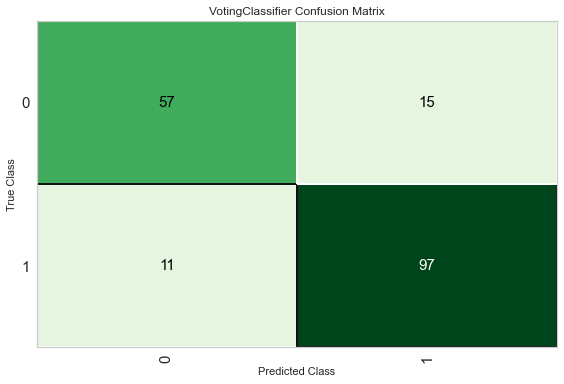

In [17]:
# plot_model(blended_model, 'auc')
plot_model(blended_model, 'confusion_matrix')

In [18]:
predict_model(blended_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8556,0.8449,0.8981,0.8661,0.8818,0.6963,0.6970


### Finalize the model & save it for use

In [25]:
finalized_model = finalize_model(blended_model)

In [19]:
save_model(blended_model, "../models/model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='HeartDisease',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                                                                       warm_start=False)),
                                               ('lr',
                                                LogisticRegression(C=0.431,
              

***